In [46]:
from torchtext import data
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import torch




In [51]:

# this needs to be cleaned up and data can be grouped in a more efficient way 

path= '/Users/tancredicp/Desktop/sailing_app/data/MLModified/'
all_files = glob.glob(path + "/*.csv")

TAGS = data.Field(unk_token = None)
TAGS.build_vocab(['0','S', 'C','G','T','B','D', 'A'])

DataLatLon = []
Data = []
for filename in all_files:
    temporary_dict = {}

    dfSpecific = pd.read_csv(filename, index_col=0, header=0)
    dfSpecific.fillna(0, inplace= True)
    
    dfSpecificY = dfSpecific['tag']
    Yarray = TAGS.numericalize((np.array(dfSpecificY)))
    
    #change to fixed number
    ynval =  9 #np.max(np.array(Yarray)) + 1
    Yarray = np.eye(ynval)[Yarray[0]]
    Yarray = torch.tensor(Yarray).unsqueeze(0)
    
    
    
    temporary_dict['tags'] = Yarray
    

    dfSpecificX = dfSpecific.drop(columns=['tag', 'lat', 'lon'])
    
    dfMetaData = dfSpecific[['tag', 'lat', 'lon']]
    DataLatLon.append(dfMetaData)
    
#     scaler = StandardScaler()
#     dfSpecificX = scaler.fit_transform(dfSpecificX)
    
    array1 = np.array(dfSpecificX)
    
    temp = torch.from_numpy(array1)
    
    temporary_dict['track'] = temp.unsqueeze(0)
    
    Data.append(temporary_dict)
    del(temporary_dict)


In [32]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm1 = nn.GRU(batch_first= True, input_size =5, hidden_size = 8, bidirectional= True, dropout = 0.9)
        self.fcn1 = nn.Linear(16, 9)
#         self.fcn2 = nn.Linear(512, 512)
#         self.fcn3 = nn.Linear(512, 9)
        
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):

        x, _ = self.lstm1(x)


        x = F.relu(self.fcn1(x))
#         x = F.dropout(x, p = 0.5)
#         x = F.relu(self.fcn2(x))
#         x = F.dropout(x, p = 0.5)
#         x = F.relu(self.fcn3(x))
#         x = F.dropout(x, p = 0.9)
#         x =x.squeeze(1)
  
        
        x = self.softmax(x)
        
        return x


In [33]:
import torch.optim as optim

net = Net()



In [34]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [35]:
len(Data)

24

In [36]:
X = Data[0]['track'].float()
y = Data[0]['tags'].float()

In [37]:
X.type(), y.type(), X.shape, y.shape

('torch.FloatTensor',
 'torch.FloatTensor',
 torch.Size([1, 3593, 5]),
 torch.Size([1, 3593, 9]))

In [53]:
for epoch in range(10000):
    
    optimizer.zero_grad()
    
    running_loss = 0.0
    
    for i in Data:
#         print('a')
        X = i['track'].float()
        y = i['tags'].float()
        
        o2 = y.argmax(2).flatten()
#         print(Counter(np.array(o2)))
        
        outputs = net(X)
        
#         print(outputs.shape, y.shape)

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    
    
    if epoch % 1== 0: 
        
        ##THIS IS WRONG - the score will only be for last race 
        
        o1 = (outputs.detach().argmax(2).flatten())
        o2 = y.argmax(2).flatten()
        acc = accuracy_score(o1, o2)
        print("Epoch: ", epoch, "Loss: ", running_loss, "Accuracy:", acc) 

Epoch:  0 Loss:  1.189698401838541 Accuracy: 0.6590709903593339
Epoch:  1 Loss:  1.2447215262800455 Accuracy: 0.6437335670464505
Epoch:  2 Loss:  1.1264137215912342 Accuracy: 0.8277826468010517
Epoch:  3 Loss:  1.114902786910534 Accuracy: 0.7730061349693251
Epoch:  4 Loss:  1.1064645051956177 Accuracy: 0.7423312883435583
Epoch:  5 Loss:  1.0803680308163166 Accuracy: 0.7791411042944786
Epoch:  6 Loss:  1.0713301338255405 Accuracy: 0.7655565293602103
Epoch:  7 Loss:  1.0547948144376278 Accuracy: 0.7467134092900964
Epoch:  8 Loss:  1.0351774040609598 Accuracy: 0.7467134092900964
Epoch:  9 Loss:  1.0013660807162523 Accuracy: 0.8418054338299737
Epoch:  10 Loss:  1.0514160208404064 Accuracy: 0.7028921998247152
Epoch:  11 Loss:  1.0519902724772692 Accuracy: 0.7914110429447853
Epoch:  12 Loss:  1.0307346917688847 Accuracy: 0.8514460999123575
Epoch:  13 Loss:  1.01102009229362 Accuracy: 0.7072743207712533
Epoch:  14 Loss:  1.0174940843135118 Accuracy: 0.8374233128834356
Epoch:  15 Loss:  1.0005

KeyboardInterrupt: 

In [40]:
from collections import Counter

In [41]:
Counter(np.array(o1))

Counter({7: 1510, 4: 656, 1: 13, 8: 83, 2: 20})

In [42]:
for name, man in pd.DataFrame([np.array(lon), np.array(lat), np.array(cols)]).T.groupby(2):
    print(man[0])
    break

NameError: name 'lon' is not defined

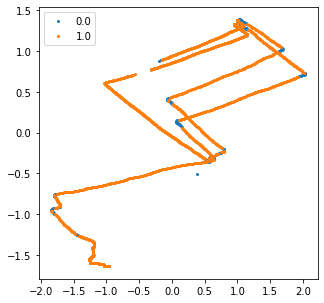

In [328]:
fig, axes = plt.subplots(1, 1, figsize = (5, 5))
for name , man in pd.DataFrame([np.array(lon), np.array(lat), np.array(cols)]).T.groupby(2):
    axes.plot(man[0], man[1], marker='o', linestyle='', ms=2, label=name)
    
    axes.legend()

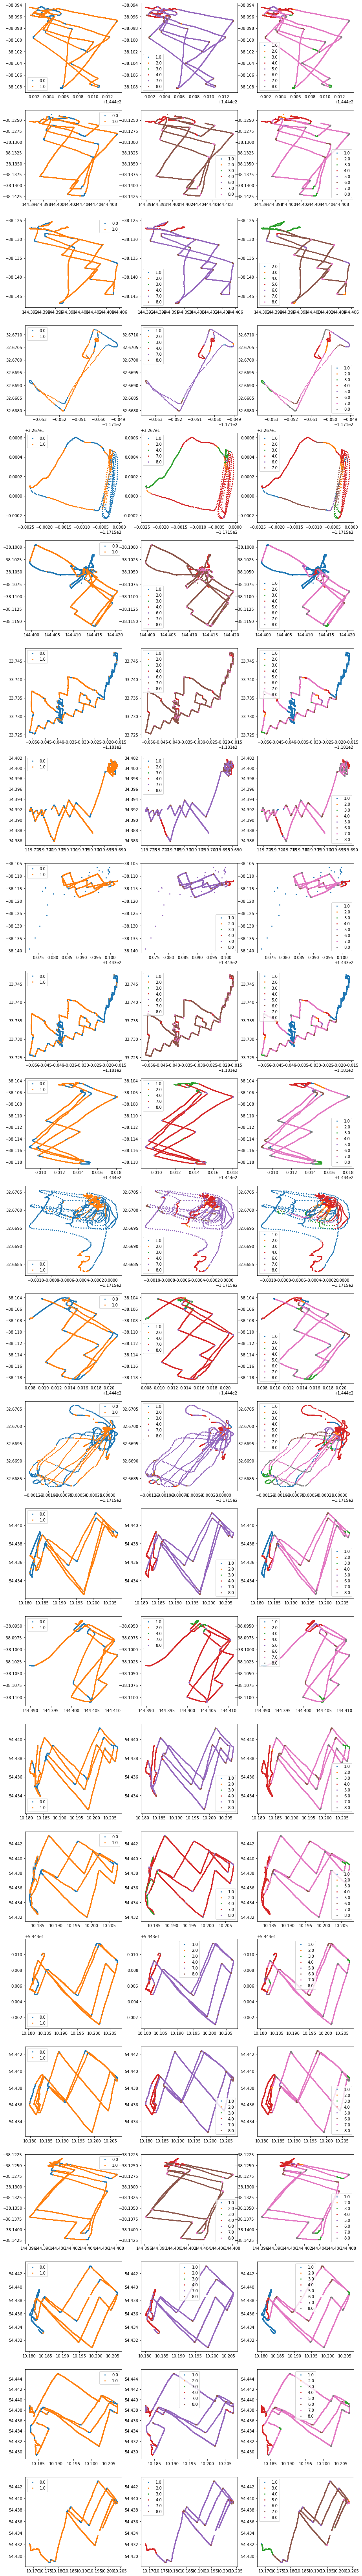

In [52]:
fig, axes = plt.subplots(24, 3, figsize = (15,120))
for i, ax, meta  in zip(Data, axes, DataLatLon):
    X = i['track'].float()
    y = i['tags'].float()
    outputs = net(X)
    o1 = (outputs.detach().argmax(2).flatten())
#     print(Counter(np.array(o1)))
    o2 = y.argmax(2).flatten()
    acc = accuracy_score(o1, o2)
    
#     print("accuracy",  acc)
     
    lon = meta['lon'] #i['track'][0][:, 0]
    lat = meta['lat'] #i['track'][0][:, 1]
    cols = np.array(o1 == o2).astype(int)
    
    
    for name , man in pd.DataFrame([np.array(lon), np.array(lat), np.array(cols)]).T.groupby(2):
        ax[0].plot(man[0], man[1], marker='o', linestyle='', ms=2, label=name)
        ax[0].legend()
        
    for name , man in pd.DataFrame([np.array(lon), np.array(lat), np.array(o1)]).T.groupby(2):
        ax[1].plot(man[0], man[1], marker='o', linestyle='', ms=2, label=name)
        ax[1].legend()
    
    
    for name , man in pd.DataFrame([np.array(lon), np.array(lat), np.array(o2)]).T.groupby(2):
        ax[2].plot(man[0], man[1], marker='o', linestyle='', ms=2, label=name)
        ax[2].legend()
        
        
    
#     ax.scatter(np.array(lon), np.array(lat), s = 1)
#     ax.scatter(np.array(lon), np.array(lat), c = cols, s = 1)
#     ax.set_title("Accuracy: " + str(acc))


In [164]:
#colors part of track labeled incorrectly when
#takes DF with lon and lat columns, preds series, true series
def quick_check(track, preds, trues):
    fig, axes = plt.subplots()
    matches = trues.eq(preds)
    track['matches'] = matches

    groups = track.groupby('matches')
    print('Percent Correct: ' + str(100*len(groups.get_group(True))/len(track)))
    for name, group in groups:
        axes.plot(group.lat, group.lon,marker='o', linestyle='', ms=2, label=name)
    axes.set_title(f"{track['place'].any()}, {track['track_id'].any()}")
    axes.legend()